In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/iADR')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
y = pd.read_csv('./data/labels(2248).csv')
data6 = np.load('./data/gin_supervised_masking.npy')
c_X_train,k_x_test,c_Y_train,k_y_test= train_test_split(data6,y,test_size=0.1,random_state=2021)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

from keras.models import load_model

In [ ]:
# data5 = pd.read_csv('./data/fp(256).txt')
y = pd.read_csv('./data/labels(2248).csv')

In [ ]:
data6 = np.load('./data/gin_supervised_masking.npy')

In [ ]:
data5= np.array(data5)

In [ ]:
data7 = np.hstack((data5,data6))

In [ ]:
c_X_train,k_x_test,c_Y_train,k_y_test= train_test_split(data6,y,test_size=0.1,random_state=2021)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau#回调函数
# # 定义回调函数：保存最优模型                     
checkpoint = ModelCheckpoint("./model/model_context2.hdf5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             save_weights_only=False,
                             verbose=1)
# 定义回调函数：提前终止训练
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0.0001, 
                          patience = 40,
                          verbose = 3,
                          mode = 'min',
                          restore_best_weights = True)
# 定义回调函数：学习率衰减
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 10,
                              verbose = 3,
                              min_delta = 0.0001)

# 将回调函数组织为回调列表
callbacks = [earlystop,reduce_lr]

In [ ]:
results=[]
# 运行计时部分
time_start = time.time()

kfolder = KFold(n_splits=5,shuffle=True,random_state=2021)
for i, (tra_id,val_id) in enumerate(kfolder.split(c_X_train,c_Y_train)):
  print(f"***********fold-{i+1}***********")

  c_x_train = c_X_train[tra_id]
  c_y_train = c_Y_train.iloc[tra_id]

  c_x_valid = c_X_train[val_id]
  c_y_valid = c_Y_train.iloc[val_id]



  scaler = preprocessing.StandardScaler().fit(c_x_train)
  c_x_train = scaler.transform(c_x_train)

  
  scaler = preprocessing.StandardScaler().fit(c_x_valid)
  c_x_valid = scaler.transform(c_x_valid)

  

  # reshape for cnn training
  # c_x_test = np.array(c_x_test).reshape(c_x_test.shape[0], c_x_test.shape[1],1)
  c_x_valid = np.array(c_x_valid).reshape(c_x_valid.shape[0], c_x_valid.shape[1],1)
  c_x_train = np.array(c_x_train).reshape(c_x_train.shape[0], c_x_train.shape[1],1)




  masking_input = keras.Input(
      shape=(300,1), name="masking"
  )  # Variable-length sequence of ints
  FP_input = keras.Input(
      shape=(256,1), name="FP"
  ) 


  # Reduce sequence of embedded words in the title into a single 128-dimensional vector
  # FP_masking_features = layers.Conv1D(16, 2, activation="relu")(FP_masking_input)
  # FP_masking_features2 = layers.Conv2D(32, 3, activation="relu")(FP_masking_features1)
  # FP_masking_features = layers.MaxPooling1D(3)(FP_masking_features)

  # FP_masking_features = layers.LSTM(300)(FP_masking_features)
  masking_features = layers.Flatten()(masking_input)

  FP_flat = layers.Flatten()(FP_nput)
  # FP_masking_flat = layers.LSTM(300)(FP_masking_flat)

  # Merge all available features into a single large vector via concatenation
  x = layers.concatenate([masking_flat,FP_flat])

  # Stick a logistic regression for priority prediction on top of the features
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(1024,activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  # x = layers.Dense(512,activation="relu")(x)
  # x = layers.Dropout(0.4)(x)
  priority_pred = layers.Dense(27, activation="sigmoid",name="priority")(x)

  model = keras.Model(inputs=[masking_input,FP_input],outputs=[priority_pred])





  opt = Adam(learning_rate=0.001)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)
    
  # training
  history = model.fit({"masking": c_x_train,"FP":},{"priority": c_y_train.values},epochs=100,batch_size=128,
                      validation_data=(c_x_valid, c_y_valid.values),callbacks=callbacks,)


  baseline_results = model.evaluate(c_x_valid, c_y_valid.values, verbose=0)
  for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
  print()


  # model.save('./model/model_masking_5fold'+str(i+1)+'.h5')

  result = np.array(baseline_results)
  results.append(result)



print("******************************************************************")
print(np.array(results))

print(f"-Accuracy score_mean:{np.mean(np.array(results)[:,[1]])}")
print(f"-Accuracy score_mean:{np.array(results)[:,[1]]}")
print(f"-Accuracy score_mean:{np.std(np.array(results)[:,[1]])}")

print(f"-Precision score_mean:{np.mean(np.array(results)[:,[2]])}")
print(f"-Precision score_mean:{np.std(np.array(results)[:,[2]])}")

print(f"-Recall score_mean:{np.mean(np.array(results)[:,[3]])}")
print(f"-Recall score_mean:{np.std(np.array(results)[:,[3]])}")

print(f"-AUC score_mean:{np.mean(np.array(results)[:,[4]])}")
print(f"-AUC score_mean:{np.std(np.array(results)[:,[4]])}")

print(f"-AUPR score_mean:{np.mean(np.array(results)[:,[5]])}")
print(f"-AUPR score_mean:{np.std(np.array(results)[:,[5]])}")






    
# 运行计时部分
time_end = time.time()
print(f"total running time: {(time_end - time_start)/60} minites")

***********fold-1***********
Epoch 1/100
13/13 [==============================] - 3s 123ms/step - loss: 0.5750 - accuracy: 0.7298 - precision: 0.7652 - recall: 0.8081 - AUC: 0.5645 - AUPR: 0.6523 - val_loss: 0.4992 - val_accuracy: 0.7629 - val_precision: 0.7604 - val_recall: 0.8730 - val_AUC: 0.6249 - val_AUPR: 0.6593
Epoch 2/100
13/13 [==============================] - 1s 49ms/step - loss: 0.5194 - accuracy: 0.7517 - precision: 0.7733 - recall: 0.8414 - AUC: 0.5865 - AUPR: 0.6626 - val_loss: 0.4900 - val_accuracy: 0.7658 - val_precision: 0.7545 - val_recall: 0.8938 - val_AUC: 0.6342 - val_AUPR: 0.6706
Epoch 3/100
13/13 [==============================] - 1s 48ms/step - loss: 0.4994 - accuracy: 0.7628 - precision: 0.7865 - recall: 0.8410 - AUC: 0.6139 - AUPR: 0.6807 - val_loss: 0.4829 - val_accuracy: 0.7682 - val_precision: 0.7575 - val_recall: 0.8927 - val_AUC: 0.6556 - val_AUPR: 0.6782
Epoch 4/100
13/13 [==============================] - 1s 48ms/step - loss: 0.4851 - accuracy: 0.7722 

In [ ]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='AUC',multi_label=True,num_labels=27,num_thresholds=498),
      keras.metrics.AUC(name='AUPR',curve='PR',multi_label=True,num_labels=27,num_thresholds=498), # precision-recall curve
]

def create_model4(metrics=METRICS):
  model = Sequential([
    # layers.LSTM(256),
    layers.Flatten(name="my_intermediate_layer"),
    layers.Dropout(0.4),
      
    layers.Dense(1024,name="my_feature"),
    layers.ReLU(),
    layers.Dropout(0.4),
    # layers.Dense(512),
    # layers.ReLU(),
    # layers.Dropout(0.4),
    # layers.Dense(256),
    # layers.ReLU(),
    # layers.Dropout(0.4),
    # layers.Dense(54),
    # layers.ReLU(),
    # layers.Dropout(0.4),
    layers.Dense(27, activation='sigmoid', name="my_last_layer"),
    ])
  return model

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
results=[]
# 运行计时部分
time_start = time.time()

kfolder = KFold(n_splits=5,shuffle=True,random_state=2021)
for i, (tra_id,val_id) in enumerate(kfolder.split(c_X_train,c_Y_train)):
  print(f"***********fold-{i+1}***********")

  c_x_train = c_X_train[tra_id]
  c_y_train = c_Y_train.iloc[tra_id]

  c_x_valid = c_X_train[val_id]
  c_y_valid = c_Y_train.iloc[val_id]



  # scaler = preprocessing.StandardScaler().fit(c_x_train)
  # c_x_train = scaler.transform(c_x_train)

  
  # scaler = preprocessing.StandardScaler().fit(c_x_valid)
  # c_x_valid = scaler.transform(c_x_valid)

  

  # reshape for cnn training
  # c_x_test = np.array(c_x_test).reshape(c_x_test.shape[0], c_x_test.shape[1],1)
  c_x_valid = np.array(c_x_valid).reshape(c_x_valid.shape[0], c_x_valid.shape[1],1)
  c_x_train = np.array(c_x_train).reshape(c_x_train.shape[0], c_x_train.shape[1],1)
    
  model = create_model4()

  opt = Adam(learning_rate=0.001)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)
    
  # training
  history = model.fit(c_x_train, c_y_train.values, batch_size=128, epochs=300,validation_data=(c_x_valid, c_y_valid.values),
                      callbacks=callbacks)


  baseline_results = model.evaluate(c_x_valid, c_y_valid.values, verbose=0)
  for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
  print()


  model.save('./model/model_FP_masking_cross'+str(i+1)+'.h5')

  result = np.array(baseline_results)
  results.append(result)



print("******************************************************************")
print(np.array(results))

print(f"-Accuracy score_mean:{np.mean(np.array(results)[:,[1]])}")
print(f"-Accuracy score_mean:{np.array(results)[:,[1]]}")
print(f"-Accuracy score_mean:{np.std(np.array(results)[:,[1]])}")

print(f"-Precision score_mean:{np.mean(np.array(results)[:,[2]])}")
print(f"-Precision score_mean:{np.std(np.array(results)[:,[2]])}")

print(f"-Recall score_mean:{np.mean(np.array(results)[:,[3]])}")
print(f"-Recall score_mean:{np.std(np.array(results)[:,[3]])}")

print(f"-AUC score_mean:{np.mean(np.array(results)[:,[4]])}")
print(f"-AUC score_mean:{np.std(np.array(results)[:,[4]])}")

print(f"-AUPR score_mean:{np.mean(np.array(results)[:,[5]])}")
print(f"-AUPR score_mean:{np.std(np.array(results)[:,[5]])}")






    
# 运行计时部分
time_end = time.time()
print(f"total running time: {(time_end - time_start)/60} minites")

***********fold-1***********
Epoch 1/300
13/13 [==============================] - 3s 90ms/step - loss: 0.8564 - accuracy: 0.7070 - precision: 0.7505 - recall: 0.7853 - AUC: 0.5583 - AUPR: 0.6440 - val_loss: 0.5635 - val_accuracy: 0.7369 - val_precision: 0.7293 - val_recall: 0.8808 - val_AUC: 0.6151 - val_AUPR: 0.6452
Epoch 2/300
13/13 [==============================] - 0s 20ms/step - loss: 0.6154 - accuracy: 0.7302 - precision: 0.7649 - recall: 0.8080 - AUC: 0.5842 - AUPR: 0.6608 - val_loss: 0.5103 - val_accuracy: 0.7594 - val_precision: 0.7561 - val_recall: 0.8739 - val_AUC: 0.6274 - val_AUPR: 0.6535
Epoch 3/300
13/13 [==============================] - 0s 21ms/step - loss: 0.5354 - accuracy: 0.7503 - precision: 0.7824 - recall: 0.8205 - AUC: 0.6122 - AUPR: 0.6763 - val_loss: 0.5156 - val_accuracy: 0.7637 - val_precision: 0.7540 - val_recall: 0.8896 - val_AUC: 0.6358 - val_AUPR: 0.6603
Epoch 4/300
13/13 [==============================] - 0s 20ms/step - loss: 0.5054 - accuracy: 0.7643 -

In [ ]:
model.evaluate(c_x_test,c_y_test,return_dict=True)

8/8 [==============================] - 1s 6ms/step - loss: 0.4384 - accuracy: 0.7979 - precision: 0.8241 - recall: 0.8691 - AUC: 0.7203 - AUPR: 0.7723


{'AUC': 0.7202785611152649,
 'AUPR': 0.7722816467285156,
 'accuracy': 0.7978600859642029,
 'loss': 0.4383724331855774,
 'precision': 0.8240898847579956,
 'recall': 0.869105875492096}

In [ ]:
results = np.array(results)

In [ ]:
results[:,[0,1]]

array([[0.45393258, 0.79259253],
       [0.44793907, 0.7912758 ],
       [0.47174028, 0.77547336],
       [0.46548608, 0.78016984],
       [0.46501675, 0.78833622]])

In [ ]:
#加载最佳参数，重新训练整个训练集+验证集，再将训练好的模型在测试集上测试
from keras.models import load_model


model2 = load_model('./model/model_FP_masking_cross5.h5')
opt = Adam(learning_rate=0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

scaler = preprocessing.StandardScaler().fit(c_X_train)
c_X_train = scaler.transform(c_X_train)

scaler = preprocessing.StandardScaler().fit(c_x_test)
c_x_test = scaler.transform(c_x_test)


history  = model2.fit(c_X_train,c_Y_train,batch_size=128, epochs=400,validation_data=(c_x_test,c_y_test),callbacks=callbacks)
# history  = model2.fit(c_X_train,c_Y_train,batch_size=128, epochs=400)
model2.evaluate(c_x_test,c_y_test,return_dict=True)

Epoch 1/400
16/16 [==============================] - 3s 75ms/step - loss: 0.8837 - accuracy: 0.7700 - precision: 0.8076 - recall: 0.8187 - AUC: 0.6850 - AUPR: 0.7126 - val_loss: 0.6622 - val_accuracy: 0.7376 - val_precision: 0.8144 - val_recall: 0.7632 - val_AUC: 0.6279 - val_AUPR: 0.7016
Epoch 2/400
16/16 [==============================] - 0s 17ms/step - loss: 0.5805 - accuracy: 0.7809 - precision: 0.8200 - recall: 0.8197 - AUC: 0.7375 - AUPR: 0.7479 - val_loss: 0.5426 - val_accuracy: 0.7845 - val_precision: 0.8185 - val_recall: 0.8516 - val_AUC: 0.6529 - val_AUPR: 0.7191
Epoch 3/400
16/16 [==============================] - 0s 19ms/step - loss: 0.5050 - accuracy: 0.7938 - precision: 0.8261 - recall: 0.8370 - AUC: 0.7544 - AUPR: 0.7616 - val_loss: 0.4862 - val_accuracy: 0.7834 - val_precision: 0.8243 - val_recall: 0.8400 - val_AUC: 0.6868 - val_AUPR: 0.7477
Epoch 4/400
16/16 [==============================] - 0s 18ms/step - loss: 0.4704 - accuracy: 0.7995 - precision: 0.8244 - recall: 

{'AUC': 0.7400299906730652,
 'AUPR': 0.7887771725654602,
 'accuracy': 0.8113579750061035,
 'loss': 0.4315369725227356,
 'precision': 0.8473457098007202,
 'recall': 0.8595722913742065}

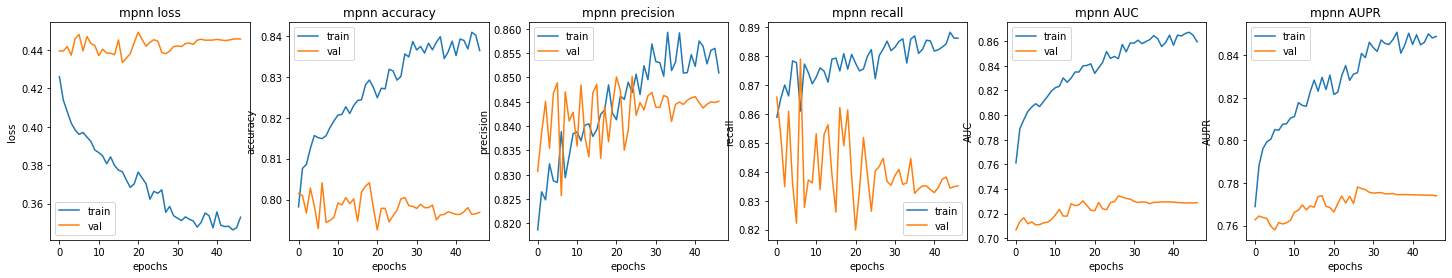

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(25, 4))
ax = ax.ravel()

for i, met in enumerate(["loss","accuracy",'precision','recall','AUC','AUPR']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("mpnn {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

# 模型融合

In [ ]:
# from keras.models import load_model
# model2 = load_model('./model/model_FP22.h5')

y_pre1 = model2.predict(c_x_test)

**gin_edge**

In [ ]:
X1 = np.load('./data/gin_supervised_edgepred.npy')
x1_train,x1_test,y_train,y_test= train_test_split(X1,y,test_size=0.1,random_state=2021)
model1 = load_model('./model/model_edgepred22.h5')

opt = Adam(learning_rate=0.001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

history  = model1.fit(x1_train,y_train,batch_size=128, epochs=400,validation_data=(x1_test,y_test),callbacks=callbacks)
model1.evaluate(x1_test,y_test,return_dict=True)


In [ ]:
x1_train,x1_test,y_train,y_test= train_test_split(X1,y,test_size=0.1,random_state=2021)

In [ ]:
model1 = load_model('./model/model_edgepred22.h5')

opt = Adam(learning_rate=0.001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

history  = model1.fit(x1_train,y_train,batch_size=128, epochs=400,validation_data=(x1_test,y_test),callbacks=callbacks)
# history  = model2.fit(c_X_train,c_Y_train,batch_size=128, epochs=400)
model1.evaluate(x1_test,y_test,return_dict=True)

Epoch 1/400
16/16 [==============================] - 3s 67ms/step - loss: 0.4080 - accuracy: 0.8151 - precision: 0.8258 - recall: 0.8819 - AUC: 0.7884 - AUPR: 0.7865 - val_loss: 0.4203 - val_accuracy: 0.8104 - val_precision: 0.8339 - val_recall: 0.8781 - val_AUC: 0.7356 - val_AUPR: 0.7748
Epoch 2/400
16/16 [==============================] - 0s 12ms/step - loss: 0.4070 - accuracy: 0.8147 - precision: 0.8302 - recall: 0.8740 - AUC: 0.7913 - AUPR: 0.7916 - val_loss: 0.4197 - val_accuracy: 0.8107 - val_precision: 0.8255 - val_recall: 0.8923 - val_AUC: 0.7371 - val_AUPR: 0.7749
Epoch 3/400
16/16 [==============================] - 0s 11ms/step - loss: 0.4007 - accuracy: 0.8166 - precision: 0.8197 - recall: 0.8954 - AUC: 0.8028 - AUPR: 0.7968 - val_loss: 0.4228 - val_accuracy: 0.8114 - val_precision: 0.8403 - val_recall: 0.8701 - val_AUC: 0.7388 - val_AUPR: 0.7758
Epoch 4/400
16/16 [==============================] - 0s 12ms/step - loss: 0.3978 - accuracy: 0.8205 - precision: 0.8336 - recall: 

{'AUC': 0.7481955885887146,
 'AUPR': 0.7821268439292908,
 'accuracy': 0.812016487121582,
 'loss': 0.4158090353012085,
 'precision': 0.8389012813568115,
 'recall': 0.8734862208366394}

In [ ]:
y_pre2 = model1.predict(x1_test)

gin_infomax

In [ ]:
X2 = np.load('./data/gin_supervised_infomax.npy')
x2_train,x2_test,y_train,y_test= train_test_split(X2,y,test_size=0.1,random_state=2021)
model3 = load_model('./model/model_infomax21.h5')

opt = Adam(learning_rate=0.001)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

history  = model3.fit(x2_train,y_train,batch_size=128, epochs=400,validation_data=(x2_test,y_test),callbacks=callbacks)
model3.evaluate(x2_test,y_test,return_dict=True)

Epoch 1/400
16/16 [==============================] - 3s 65ms/step - loss: 0.4037 - accuracy: 0.8134 - precision: 0.8287 - recall: 0.8757 - AUC: 0.7912 - AUPR: 0.7917 - val_loss: 0.4267 - val_accuracy: 0.8081 - val_precision: 0.8313 - val_recall: 0.8776 - val_AUC: 0.7316 - val_AUPR: 0.7694
Epoch 2/400
16/16 [==============================] - 0s 12ms/step - loss: 0.4007 - accuracy: 0.8164 - precision: 0.8237 - recall: 0.8881 - AUC: 0.8024 - AUPR: 0.7993 - val_loss: 0.4309 - val_accuracy: 0.8015 - val_precision: 0.8343 - val_recall: 0.8601 - val_AUC: 0.7299 - val_AUPR: 0.7679
Epoch 3/400
16/16 [==============================] - 0s 12ms/step - loss: 0.3942 - accuracy: 0.8217 - precision: 0.8312 - recall: 0.8869 - AUC: 0.8090 - AUPR: 0.8014 - val_loss: 0.4248 - val_accuracy: 0.8095 - val_precision: 0.8312 - val_recall: 0.8807 - val_AUC: 0.7324 - val_AUPR: 0.7686
Epoch 4/400
16/16 [==============================] - 0s 12ms/step - loss: 0.3943 - accuracy: 0.8212 - precision: 0.8329 - recall: 

{'AUC': 0.748471736907959,
 'AUPR': 0.7741188406944275,
 'accuracy': 0.8123456239700317,
 'loss': 0.4174900949001312,
 'precision': 0.8322424292564392,
 'recall': 0.8845658302307129}

In [ ]:
y_pre3 = model3.predict(x2_test)

**gin_masking**

In [ ]:
X3 = np.load('./data/gin_supervised_masking.npy')
x3_train,x3_test,y_train,y_test= train_test_split(X3,y,test_size=0.1,random_state=2021)
model4 = load_model('./model/model_masking22.h5')

opt = Adam(learning_rate=0.001)
model4.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

history  = model4.fit(x3_train,y_train,batch_size=128, epochs=400,validation_data=(x3_test,y_test))
model4.evaluate(x3_test,y_test,return_dict=True)

Epoch 1/400
16/16 [==============================] - 3s 64ms/step - loss: 0.4179 - accuracy: 0.8091 - precision: 0.8242 - recall: 0.8741 - AUC: 0.7678 - AUPR: 0.7742 - val_loss: 0.4367 - val_accuracy: 0.8046 - val_precision: 0.8265 - val_recall: 0.8786 - val_AUC: 0.7053 - val_AUPR: 0.7560
Epoch 2/400
16/16 [==============================] - 0s 12ms/step - loss: 0.4111 - accuracy: 0.8136 - precision: 0.8231 - recall: 0.8834 - AUC: 0.7831 - AUPR: 0.7855 - val_loss: 0.4354 - val_accuracy: 0.8067 - val_precision: 0.8317 - val_recall: 0.8745 - val_AUC: 0.7081 - val_AUPR: 0.7568
Epoch 3/400
16/16 [==============================] - 0s 12ms/step - loss: 0.4053 - accuracy: 0.8172 - precision: 0.8235 - recall: 0.8901 - AUC: 0.7934 - AUPR: 0.7853 - val_loss: 0.4361 - val_accuracy: 0.8061 - val_precision: 0.8386 - val_recall: 0.8624 - val_AUC: 0.7108 - val_AUPR: 0.7588
Epoch 4/400
16/16 [==============================] - 0s 11ms/step - loss: 0.4057 - accuracy: 0.8163 - precision: 0.8306 - recall: 

{'AUC': 0.7567673325538635,
 'AUPR': 0.7816628813743591,
 'accuracy': 0.8159670829772949,
 'loss': 0.45568355917930603,
 'precision': 0.8532344698905945,
 'recall': 0.8598299622535706}

In [ ]:
y_pre4 = model4.predict(x3_test)

gin_context

In [ ]:
X4 = np.load('./data/gin_supervised_contextpred.npy')
x4_train,x4_test,y_train,y_test= train_test_split(X4,y,test_size=0.1,random_state=2021)
model5 = load_model('./model/model_context21.h5')

opt = Adam(learning_rate=0.001)
model3.compile(loss='binary_crossentropy', optimizer=opt, metrics=METRICS)

history  = model5.fit(x4_train,y_train,batch_size=128, epochs=400)
model5.evaluate(x4_test,y_test,return_dict=True)

Epoch 1/400
16/16 [==============================] - 2s 10ms/step - loss: 0.3990 - accuracy: 0.8201 - precision: 0.8255 - recall: 0.8927 - AUC: 0.7986 - AUPR: 0.7959
Epoch 2/400
16/16 [==============================] - 0s 10ms/step - loss: 0.4010 - accuracy: 0.8161 - precision: 0.8219 - recall: 0.8906 - AUC: 0.7990 - AUPR: 0.7951
Epoch 3/400
16/16 [==============================] - 0s 10ms/step - loss: 0.3994 - accuracy: 0.8171 - precision: 0.8222 - recall: 0.8921 - AUC: 0.8019 - AUPR: 0.7961
Epoch 4/400
16/16 [==============================] - 0s 10ms/step - loss: 0.3952 - accuracy: 0.8213 - precision: 0.8272 - recall: 0.8925 - AUC: 0.8076 - AUPR: 0.8007
Epoch 5/400
16/16 [==============================] - 0s 11ms/step - loss: 0.3931 - accuracy: 0.8224 - precision: 0.8279 - recall: 0.8936 - AUC: 0.8092 - AUPR: 0.8002
Epoch 6/400
16/16 [==============================] - 0s 11ms/step - loss: 0.3959 - accuracy: 0.8200 - precision: 0.8260 - recall: 0.8918 - AUC: 0.8055 - AUPR: 0.7974
Epoc

{'AUC': 0.7246651649475098,
 'AUPR': 0.7711918950080872,
 'accuracy': 0.8079012632369995,
 'loss': 0.42572110891342163,
 'precision': 0.8389111161231995,
 'recall': 0.8654986023902893}

In [ ]:
y_pre5 = model5.predict(x4_test)

In [ ]:
nlabel = np.array(y_test)
plabel = np.where(y_pre5 > 0.5,1,0)

aiming, coverage, accuracy, absolute_true, absolute_false = validation(plabel, nlabel)

In [ ]:
aiming, coverage, accuracy, absolute_true, absolute_false

(0.8301208476641239,
 0.8668982425136816,
 0.7244053497074668,
 0.04888888888888889,
 0.19209876543209886)

In [ ]:
m1 = keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5)
m2 = keras.metrics.Precision(name='precision')
m3 = keras.metrics.Recall(name='recall')
m4 = keras.metrics.AUC(name='AUC',multi_label=True,num_labels=27,num_thresholds=498)
m5 = keras.metrics.AUC(name='AUPR',curve='PR',multi_label=True,num_labels=27,num_thresholds=498)

In [ ]:
m1.update_state(y_test,y_pre12345)
m2.update_state(y_test,y_pre12345)
m3.update_state(y_test,y_pre12345)
m4.update_state(y_test,y_pre12345)
m5.update_state(y_test,y_pre12345)

In [ ]:
print(f"-Accuracy score_mean:{m1.result().numpy()}")


print(f"-Precision score_mean:{m2.result().numpy()}")


print(f"-Recall score_mean:{m3.result().numpy()}")


print(f"-AUC score_mean:{m4.result().numpy()}")


print(f"-AUPR score_mean:{m5.result().numpy()}")



-Accuracy score_mean:0.807953953742981
-Precision score_mean:0.8502597212791443
-Recall score_mean:0.8626877069473267
-AUC score_mean:0.7449020743370056
-AUPR score_mean:0.7810348272323608


In [ ]:
m[0].result().numpy()

0.0

In [ ]:
y_pre24 = (y_pre2+y_pre4)/2

In [ ]:
y_pre12 = (y_pre1+y_pre2)/2

In [ ]:
y_pre13 = (y_pre1+y_pre3)/2

In [ ]:
y_pre14 = (y_pre1+y_pre4)/2

In [ ]:
y_test = np.array(y_test)

In [ ]:
y_pre15 = (y_pre1+y_pre5)/2

In [ ]:
y_pre135 = (y_pre1+y_pre3+y_pre5)/3

In [ ]:
y_pre345 = (y_pre4+y_pre3+y_pre5)/3

In [ ]:
y_pre1345 = (y_pre1+y_pre4+y_pre3+y_pre5)/4

In [ ]:
y_pre12345 = (y_pre1+y_pre4+y_pre3+y_pre5)/5

# 子模型融合

In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/iADR')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
y = pd.read_csv('./data/labels(2248).csv')
data6 = np.load('./data/gin_supervised_masking.npy')
c_X_train,k_x_test,c_Y_train,k_y_test= train_test_split(data6,y,test_size=0.1,random_state=2021)

In [2]:
m1 = keras.metrics.BinaryAccuracy(name='accuracy',threshold=0.5)
m2 = keras.metrics.Precision(name='precision')
m3 = keras.metrics.Recall(name='recall')
m4 = keras.metrics.AUC(name='AUC',multi_label=True,num_labels=27,num_thresholds=498)
m5 = keras.metrics.AUC(name='AUPR',curve='PR',multi_label=True,num_labels=27,num_thresholds=498)

In [4]:
#IADRDDI
# y_pre1 = np.load('./model/masking/masking_pre.npy')
# y_pre2 = np.load('./model/edeg/edeg_pre.npy')
# y_pre3 = np.load('./model/info/info_pre.npy')
# y_pre4 = np.load('./model/context/context_pre.npy')


# y_pre5 = np.load('./model/fp/fp_pre.npy')
# y_pre6 = np.load('./model/attfp/attfp_pre.npy')
# y_pre = (y_pre1+y_pre2+y_pre4+y_pre5+y_pre6)/5


#RF
y_pre1 = np.load('./model/masking/masking_RF_pre.npy')
y_pre2 = np.load('./model/edeg/edeg_RF_pre.npy')

y_pre3 = np.load('./model/context/context_RF_pre.npy')
y_pre4 = np.load('./model/attfp/attfp_RF_pre.npy')

y_pre5 = np.load('./model/fp/fp_RF_pre.npy')


#svm
# y_pre1 = np.load('./model/masking/masking_svm_pre.npy')
# y_pre2 = np.load('./model/edeg/edeg_svm_pre.npy')

# y_pre3 = np.load('./model/context/context_svm_pre.npy')
# y_pre4 = np.load('./model/attfp/attfp_svm_pre.npy')

# y_pre5 = np.load('./model/fp/fp_svm_pre.npy')



y_pre = (y_pre1+y_pre2+y_pre3+y_pre5+y_pre4)/5

m1.update_state(k_y_test,y_pre)
m2.update_state(k_y_test,y_pre)
m3.update_state(k_y_test,y_pre)
m4.update_state(k_y_test,y_pre)
m5.update_state(k_y_test,y_pre)

print(f"-Accuracy score_mean:{m1.result().numpy()}")


print(f"-Precision score_mean:{m2.result().numpy()}")


print(f"-Recall score_mean:{m3.result().numpy()}")


print(f"-AUC score_mean:{m4.result().numpy()}")


print(f"-AUPR score_mean:{m5.result().numpy()}")

-Accuracy score_mean:0.8169546723365784
-Precision score_mean:0.8412620425224304
-Recall score_mean:0.8794125318527222
-AUC score_mean:0.7435588836669922
-AUPR score_mean:0.7838318347930908


SVM

In [6]:
y_pre1 = np.load('./model/masking/masking_svm_pre.npy')
y_pre2 = np.load('./model/edeg/edeg_svm_pre.npy')

y_pre3 = np.load('./model/context/context_svm_pre.npy')
y_pre4 = np.load('./model/attfp/attfp_svm_pre.npy')

y_pre5 = np.load('./model/fp/fp_svm_pre.npy')



y_pre = (y_pre1+y_pre2+y_pre3+y_pre5+y_pre4)/5

m1.update_state(k_y_test,y_pre)
m2.update_state(k_y_test,y_pre)
m3.update_state(k_y_test,y_pre)
m4.update_state(k_y_test,y_pre)
m5.update_state(k_y_test,y_pre)

print(f"-Accuracy score_mean:{m1.result().numpy()}")


print(f"-Precision score_mean:{m2.result().numpy()}")


print(f"-Recall score_mean:{m3.result().numpy()}")


print(f"-AUC score_mean:{m4.result().numpy()}")


print(f"-AUPR score_mean:{m5.result().numpy()}")

-Accuracy score_mean:0.8136625289916992
-Precision score_mean:0.827495813369751
-Recall score_mean:0.8948724269866943
-AUC score_mean:0.728751003742218
-AUPR score_mean:0.7855202555656433


# DeepDDI

In [9]:
y_pre1 = np.load('./model/masking/masking_DDI_pre.npy')
y_pre2 = np.load('./model/edeg/fp_edeg_pre.npy')

y_pre3 = np.load('./model/context/context_DDI_pre.npy')
y_pre4 = np.load('./model/attfp/attfp_DDI_pre.npy')

y_pre5 = np.load('./model/fp/fp_DDI_pre.npy')



y_pre = (y_pre1+y_pre2+y_pre3+y_pre5+y_pre4)/5

m1.update_state(k_y_test,y_pre)
m2.update_state(k_y_test,y_pre)
m3.update_state(k_y_test,y_pre)
m4.update_state(k_y_test,y_pre)
m5.update_state(k_y_test,y_pre)

print(f"-Accuracy score_mean:{m1.result().numpy()}")


print(f"-Precision score_mean:{m2.result().numpy()}")


print(f"-Recall score_mean:{m3.result().numpy()}")


print(f"-AUC score_mean:{m4.result().numpy()}")


print(f"-AUPR score_mean:{m5.result().numpy()}")

-Accuracy score_mean:0.8031275868415833
-Precision score_mean:0.8195667862892151
-Recall score_mean:0.8871424794197083
-AUC score_mean:0.7314255833625793
-AUPR score_mean:0.7429443597793579
